In [29]:
import sys
import re

from src.database.firebase_manager import get_firebase_data, connect_to_firebase
sys.path.append("../")
connect_to_firebase()
import pandas as pd
import numpy as np
import folium




In [32]:
data_perdiz = get_firebase_data("Perdizes, São Paulo, São Paulo")
data_consol = get_firebase_data("Consolação, São Paulo")
data_liberd = get_firebase_data("Liberdade, São Paulo, SP")

df_perdiz = pd.DataFrame(data_perdiz)
df_consol = pd.DataFrame(data_consol)
df_liberd = pd.DataFrame(data_liberd)

In [33]:
df_consol

,banheiros,distance,endereço,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,1,32.672785,"01309-030, Consolação, São Paulo, Estado de Sã...",-23.554068,https://rd.clk.thribee.com/id.1d1C1NQad1vA/ori...,-46.657645,2500,1,trovit,"Apto, Consolação, 1 Quarto, 42 m2 - São Paulo\...",42,NaN,NaN
1,1,32.666171,"01306-010, Consolação, São Paulo, Estado de Sã...",-23.554817,https://rd.clk.thribee.com/id.1iP161L461cD/ori...,-46.649040,2400,1,trovit,"Apto, Consolação, 1 Quarto, 50 m2 - São Paulo\...",50,NaN,NaN
2,1,32.666679,"01306-001, Consolação, São Paulo, Estado de Sã...",-23.550563,https://rd.clk.thribee.com/id.1JM1C1q-ZL17/ori...,-46.645503,930,1,trovit,"Apto, Consolação, 1 Quarto, 17 m2 - São Paulo\...",17,NaN,NaN
3,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.16s1U18i1w1ng/or...,-46.646067,2000,2,trovit,"Apto, Consolação, 2 Quarto, 47 m2 - São Paulo\...",47,NaN,NaN
4,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.1M_g3P1S1fK/orig...,-46.646067,2800,1,trovit,"Apto, Consolação, 1 Quarto, 34 m2 - São Paulo\...",34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2,32.672845,"Rua Maria Antônia - Consolação, São Paulo - SP",-23.546764,https://www.vivareal.com.br/imovel/2523113159,-46.650425,2000,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 76m²\n...",76,0.0,464.0
85,1,32.667839,"Rua Caio Prado, 363 - Consolação, São Paulo - SP",-23.551151,https://www.vivareal.com.br/imovel/2534477021,-46.647732,3200,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 55m²\n...",55,1.0,625.0
86,2,32.670117,"Rua Frei Caneca - Consolação, São Paulo - SP",-23.559038,https://www.vivareal.com.br/imovel/2531152400,-46.658842,2600,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 62m²\n...",62,1.0,556.0
87,1,32.674121,"Rua Dona Antônia de Queirós, 523 - Consolação,...",-23.548963,https://www.vivareal.com.br/imovel/2512676180,-46.654429,2000,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 80m²\n...",80,0.0,242.0


In [34]:
df = pd.concat([df_consol, df_perdiz, df_liberd], ignore_index = True)
df

,banheiros,distance,endereço,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,1,32.672785,"01309-030, Consolação, São Paulo, Estado de Sã...",-23.554068,https://rd.clk.thribee.com/id.1d1C1NQad1vA/ori...,-46.657645,2500,1,trovit,"Apto, Consolação, 1 Quarto, 42 m2 - São Paulo\...",42,NaN,NaN
1,1,32.666171,"01306-010, Consolação, São Paulo, Estado de Sã...",-23.554817,https://rd.clk.thribee.com/id.1iP161L461cD/ori...,-46.649040,2400,1,trovit,"Apto, Consolação, 1 Quarto, 50 m2 - São Paulo\...",50,NaN,NaN
2,1,32.666679,"01306-001, Consolação, São Paulo, Estado de Sã...",-23.550563,https://rd.clk.thribee.com/id.1JM1C1q-ZL17/ori...,-46.645503,930,1,trovit,"Apto, Consolação, 1 Quarto, 17 m2 - São Paulo\...",17,NaN,NaN
3,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.16s1U18i1w1ng/or...,-46.646067,2000,2,trovit,"Apto, Consolação, 2 Quarto, 47 m2 - São Paulo\...",47,NaN,NaN
4,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.1M_g3P1S1fK/orig...,-46.646067,2800,1,trovit,"Apto, Consolação, 1 Quarto, 34 m2 - São Paulo\...",34,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,1,32.616948,"Avenida da Aclimação - Liberdade, São Paulo - SP",-23.571002,NaN,-46.633226,1700,1,vivareal,"Apartamento com Quarto para Aluguel, 55m²\nAve...",55,0.0,600.0
263,1,32.628718,"Rua Barão de Iguape - Liberdade, São Paulo - SP",-23.558239,NaN,-46.637106,1400,1,vivareal,"Apartamento com Quarto para Aluguel, 40m²\nRua...",40,0.0,200.0
264,1,32.627808,"Rua Barão de Iguape, 985 - Liberdade, São Paul...",-23.558400,NaN,-46.635981,1800,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 49m²\n...",49,1.0,222.0
265,1,32.619992,"Rua Otto de Alencar, 315 - Liberdade, São Paul...",-23.558717,NaN,-46.625246,1650,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 47m²\n...",47,1.0,437.0


In [35]:
def skip_nans(df):
    df.vagas.fillna("Não especificado", inplace=True)
    df.quartos.fillna("Não especificado", inplace=True)
    df["área"].fillna("Não especificado", inplace=True)
skip_nans(df)
    

In [36]:
df

,banheiros,distance,endereço,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,1,32.672785,"01309-030, Consolação, São Paulo, Estado de Sã...",-23.554068,https://rd.clk.thribee.com/id.1d1C1NQad1vA/ori...,-46.657645,2500,1,trovit,"Apto, Consolação, 1 Quarto, 42 m2 - São Paulo\...",42,Não especificado,NaN
1,1,32.666171,"01306-010, Consolação, São Paulo, Estado de Sã...",-23.554817,https://rd.clk.thribee.com/id.1iP161L461cD/ori...,-46.649040,2400,1,trovit,"Apto, Consolação, 1 Quarto, 50 m2 - São Paulo\...",50,Não especificado,NaN
2,1,32.666679,"01306-001, Consolação, São Paulo, Estado de Sã...",-23.550563,https://rd.clk.thribee.com/id.1JM1C1q-ZL17/ori...,-46.645503,930,1,trovit,"Apto, Consolação, 1 Quarto, 17 m2 - São Paulo\...",17,Não especificado,NaN
3,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.16s1U18i1w1ng/or...,-46.646067,2000,2,trovit,"Apto, Consolação, 2 Quarto, 47 m2 - São Paulo\...",47,Não especificado,NaN
4,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.1M_g3P1S1fK/orig...,-46.646067,2800,1,trovit,"Apto, Consolação, 1 Quarto, 34 m2 - São Paulo\...",34,Não especificado,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,1,32.616948,"Avenida da Aclimação - Liberdade, São Paulo - SP",-23.571002,NaN,-46.633226,1700,1,vivareal,"Apartamento com Quarto para Aluguel, 55m²\nAve...",55,0,600.0
263,1,32.628718,"Rua Barão de Iguape - Liberdade, São Paulo - SP",-23.558239,NaN,-46.637106,1400,1,vivareal,"Apartamento com Quarto para Aluguel, 40m²\nRua...",40,0,200.0
264,1,32.627808,"Rua Barão de Iguape, 985 - Liberdade, São Paul...",-23.558400,NaN,-46.635981,1800,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 49m²\n...",49,1,222.0
265,1,32.619992,"Rua Otto de Alencar, 315 - Liberdade, São Paul...",-23.558717,NaN,-46.625246,1650,2,vivareal,"Apartamento com 2 Quartos para Aluguel, 47m²\n...",47,1,437.0


In [37]:
first_sixth = np.quantile(df.preço, 1/6)
last_sixth = np.quantile(df.preço, 5/6)

# Criando nosso mapa
m = folium.Map(location=[-23.537034, -46.674346], zoom_start=13)

for lat,lon,preco,n_quartos,n_banheiros,n_vagas,area,link  in zip(df.lat, df.lon, df['preço'], df['quartos'], df['banheiros'], df['vagas'], df['área'], df.link):
    html = f'''
    <table id="vertical-1">
      <caption>endereço</caption>
      <tr>
        <th>Aluguel</th>
        <td>R$ {preco},00</td>
      </tr>
      <tr>
        <th>Quartos</th>
        <td>{n_quartos}</td>
      </tr>
      <tr>
        <th>Banheiros</th>
        <td>{n_banheiros}</td>
      </tr>
      <tr>
        <th>Vagas</th>
        <td>{n_vagas}</td>
      </tr>
      <tr>
        <th>Área</th>
        <td>{area} m²</td>
      </tr>
      <tr>
        <th>link</th>
        <td><a href={link}>link</a></td>
      </tr>
    </table>'''
    iframe = folium.IFrame(html,
                       width=225,
                       height=200)
    popup = folium.Popup(iframe)
    if preco <= first_sixth:
        color="green"
    elif preco < last_sixth:
        color="orange"
    else:
        color="red"
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.Icon(icon="building", prefix="fa", color=color),
    ).add_to(m)

In [39]:
m

<AxesSubplot:xlabel='preço', ylabel='Count'>

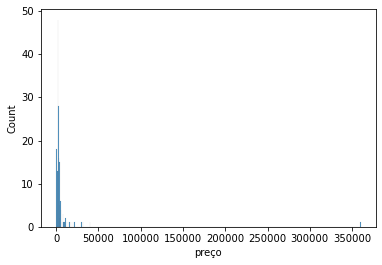

In [36]:
import seaborn as sns
sns.histplot(df.preço)

<AxesSubplot:xlabel='preço', ylabel='Count'>

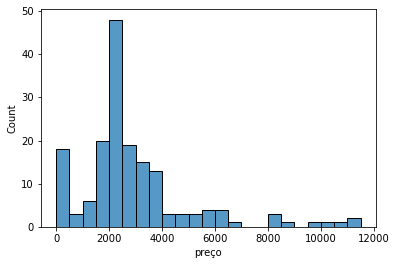

In [37]:
import seaborn as sns
sns.histplot(df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500)